In [1]:
import pickle
import pandas as pd
import re
from matplotlib import pyplot as plt
import nltk
import string
import itertools
import seaborn as sns

In [2]:
cr_df = pd.read_pickle('../pickle_jar/CritRole_split.pkl')
cr_df['text'] = cr_df['text'].str.replace(r'♫', r'', regex=True).astype('str')
cr_df = cr_df.rename(columns={'text': 'speech', 'index': 'speech_turn'})
cr_df=cr_df.drop(321664) #another full produced song (not them singing at the table) skewing the sent length data badly
cr_df=cr_df.drop(78020)  #a badly coded line (spit out some meta info it looks like) skewing word len data
cr_df

,speech_turn,name,speech,episode,timestamp,inaudible_speech,nonspeech
0,0,MATT,We've got some cool stuff to talk about. First...,1,00:00:15,,
1,1,LAURA,As in nnnn.,1,00:01:21,,
2,2,MATT,"Nnnn. But yeah, so they're going to be a long-...",1,00:01:24,,
3,3,TRAVIS,Would you like some?,1,00:02:04,,(vomiting noises)
4,4,MATT,"So yeah. I'm super excited to have that, guys....",1,00:02:07,,
...,...,...,...,...,...,...,...
434047,2722,MATT,"We're going to get through this together, guys.",99,03:47:47,,
434048,2723,SAM,Wash your stubbly face.,99,03:47:49,,
434049,2724,TRAVIS,Gross.,99,03:47:51,,
434050,2725,MATT,,99,03:47:52,,(cheering)


In [3]:
#found some name misspellings and some (confirmed) sporadic useage of character names instead of player names, but very few (weird)
cr_df['name'] = cr_df['name'].str.replace(r'MTT', r'MATT', regex=True).astype('str')
cr_df['name'] = cr_df['name'].str.replace(r'AMTT', r'MATT', regex=True).astype('str')
cr_df['name'] = cr_df['name'].str.replace(r'NOTT', r'SAM', regex=True).astype('str')
cr_df['name'] = cr_df['name'].str.replace(r'CALEB', r'LIAM', regex=True).astype('str')
cr_df['name'] = cr_df['name'].str.replace(r'BEAU', r'MARISHA', regex=True).astype('str')
cr_df['name'] = cr_df['name'].str.replace(r'JESTER', r'MATT', regex=True).astype('str')

# Table of Contents 

### Part 1

1. [Counting Lines](#Counting-Lines)
    - [Exploring Results](#Exploring-Results)<br>
    <br>
2. [Adding new columns](#Adding-new-columns)
    - [Word Counts](#Word-counts-(per-line))
    - [Words per speaker](#Total-words-per-speaker)
    - [Unique words per speaker](#Unique-words-per-speaker)
    - [Word Length](#Word-Length)
    - [Sentences and sentence length](#Sentences-and-sentence-length)<br>
<br>   
3. [Initial Conlusions](#Initial-Conlusions)

### Part 2

1. [Dividing the data by group](#Dividing-the-data-by-group)<br>
<br>
2. [Re-measuring](#Re-measuring)
    - [Lines](#Lines)
    - [Word Count](#Word-Count)
    - [Sentence Length](#Sentence-Length)<br>
    <br>
3. [Grouped Conclusions](#Grouped-Conclusions)

### Part 3

1. [Hedging](#Hedging)
2. [Jargon](#Jargon)
3. [Readability Metric](#Readability-Metric)
4. [Interruptions](#Interruptions)

## Counting Lines

First thing's first, let's just see how many lines each speaker has as a basis to go off of for the rest of our research.

The problem I had initially was counting *all* lines associated per name, including lines in the 'speech turn' column that are empty because the value had been moved to the 'nonspeech' or 'inaudible' columns instead. To combat this, I've selected only the name and text columns and dropped any row from the text column that contains no text. By doing this we've eliminated 11,474 lines from the text volume that have no value.

In [4]:
lcount = cr_df[['name', 'speech']].copy() #copy just these two cols over for now
lcount = lcount[lcount['speech'] != '']  #drop any rows with no value

In [5]:
spcount = pd.DataFrame(lcount.groupby(['name'])['speech'].count()) #speech count
spcount = spcount.reset_index()
spcount = spcount.sort_values('speech', ascending=False)
spcount.head(n=8)

,name,speech
200,MATT,109579
104,LAURA,58407
245,SAM,50447
168,MARISHA,48138
316,TRAVIS,48073
136,LIAM,40254
293,TALIESIN,39736
14,ASHLEY,17166


So here are the line counts per main cast member! Very interesting stuff. Predictably, Matt talks a *lot* more than every other participant, almost twice as much as the second most lines spoken.

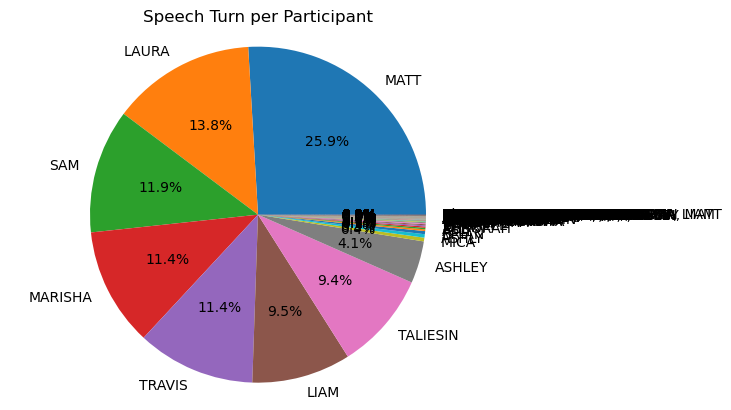

In [6]:
plt.pie(spcount['speech'], labels=spcount['name'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Speech Turn per Participant')
plt.show()

## Exploring Results

First of all, there is some important information to add some context to the information we're looking at. 

#### 1
First thing is attendance. The fan-run website [CritRole Stats](https://www.critrolestats.com/stats) tracks a number of statistics for each episode of Critical Role. The one we're looking at is Campaign 2 (Mighty Nein Campaign). They have very helpfully included attendance among their stats!<br>
Not every player was present for every single episode. Laura and Travis left for some time for parental leave, Taliesin had a character death, and Ashley was away for a time filming for a television show. This show spanned multiple years, Jan 2018 to June 2021, on a weekly basis except for a period from March to July 2020 for quarantine. It's not odd to have someone have to miss an episode sometimes.

Here is the attendance list by CR Stats:<br>
Matt      -> 141<br>
Marisha	  -> 141<br>
Sam	      -> 141<br>
Liam	  -> 140<br>
Taliesin  -> 139<br>
Travis	  -> 136<br>
Laura	  -> 133<br>
Ashley	  -> 86

Interestingly, this explains why Ashley has as few lines as she does, but otherwise there is not a 1:1 match of attendance to how much a player spoke.

#### 2
Another thing to consider is characters. Laura may have been in the second to least episodes out of the full cast, but her character, Jester, is an excitable motormouth. Marisha and Travis, on the other hand, play slightly more serious characters, and Liam, Ashley, and Taliesin (from episode 30-ish onward) play more stoic types. 

#### 3
Finally, roles. At the top of each episode (or most of them, at least), two things happen. Sam reads ads for the show, often making them into skits or scripts full of jokes and siliness. Then, often, Laura updates viewers on new merch added to their store, what's available, what's coming and when it'll be available, and so on. It wouldn't be surprising to find that this affects their speech totals by a good bit.

Since I spent so long crafting that nonspeech column let's take a look at its values just to see what we see. 

In [7]:
allsounds = cr_df['nonspeech'].value_counts()
allsounds[:15]

                408173
(laughter)        6163
(laughs)          1933
(laughs)           874
(laughter)         720
(whispering)       416
(cheering)         338
(gasps)            293
(gasps)            281
(singing)          278
(sighs)            273
(groaning)         254
(counting)         242
(sighs)            195
(groans)           174
Name: nonspeech, dtype: int64

In [8]:
scount = cr_df[['name', 'nonspeech']].copy()
scount = scount[scount['nonspeech'] != '']
nscount = pd.DataFrame(scount.groupby(['name'])['nonspeech'].count())
nscount = nscount.reset_index()
nscount = nscount.sort_values('nonspeech', ascending=False)
nscount.head(n=8)

,name,nonspeech
92,MATT,7176
142,TRAVIS,3801
49,LAURA,3311
115,SAM,3265
77,MARISHA,2451
61,LIAM,2393
134,TALIESIN,1341
10,ASHLEY,1005


Not extremely important since it's not part of speech analysis but I put the work in and I wanted to see it.
Not surprising again! Matt being the first makes sense, he is known as a DM for including sound effects (and being very good at them). Just a cool stat... moving on!

## Adding new columns

Running through the base metrics we know and love.... word tokenizing & word counts, word types, word length, sentence count and sentence length. With these metrics available, the real interpretation can begin.

### Word counts (per spoken line)

Again, keeping in mind that one speech turn may include multiple sentences.

Since this is speech and not written language, I don't want to include punctuation in the word tokenization. We're trying to measure purely what is spoken by our DND players.

In [9]:
punctuations="!@#$%^&*()_-=+:;{}[]<>,.?/\''"

In [10]:
tokens = cr_df.speech.map(nltk.word_tokenize)
cr_df['tokens']=tokens         #create token column
cr_df['nopunc']=cr_df['tokens'].apply(lambda tokens: [w for w in tokens if w not in punctuations]) #list comprehend to remove toks
cr_df = cr_df.drop('tokens', axis=1)     #drop that toks col, we don't actually want it

In [11]:
cr_df['word_count'] = cr_df.nopunc.map(len)   #count total tokens per line
cr_df.head() #pre punc removal index 0 had 179 words, so this worked pretty well for accuracy

,speech_turn,name,speech,episode,timestamp,inaudible_speech,nonspeech,nopunc,word_count
0,0,MATT,We've got some cool stuff to talk about. First...,1,00:00:15,,,"[We, 've, got, some, cool, stuff, to, talk, ab...",155
1,1,LAURA,As in nnnn.,1,00:01:21,,,"[As, in, nnnn]",3
2,2,MATT,"Nnnn. But yeah, so they're going to be a long-...",1,00:01:24,,,"[Nnnn, But, yeah, so, they, 're, going, to, be...",122
3,3,TRAVIS,Would you like some?,1,00:02:04,,(vomiting noises),"[Would, you, like, some]",4
4,4,MATT,"So yeah. I'm super excited to have that, guys....",1,00:02:07,,,"[So, yeah, I, 'm, super, excited, to, have, th...",129


So we know who has the most speech turns (Matt) but what about who says the most words? Someone with fewer speech turns (lines) could have one very very long speech, who knows.

### Total words per speaker

In [12]:
wcount = pd.DataFrame(cr_df.groupby('name').word_count.sum())
wcount = wcount.reset_index()
wcount = wcount.sort_values('word_count', ascending=False)
wcount.head(n=8)

,name,word_count
211,MATT,1385768
112,LAURA,427517
260,SAM,355003
144,LIAM,343809
337,TRAVIS,339729
176,MARISHA,334941
312,TALIESIN,311166
16,ASHLEY,103511


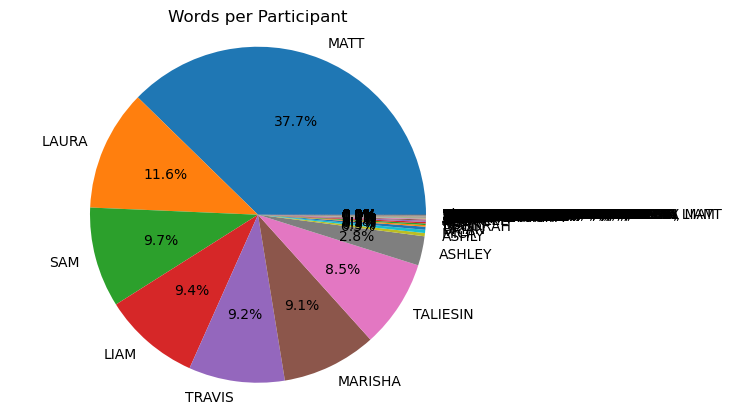

In [13]:
plt.pie(wcount['word_count'], labels=wcount['name'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Words per Participant')
plt.show()

This lines up quite nicely in line with the the speech turns divisions. For the most part, the people who have more speech turns *tend* to say more words as well. 

Liam, Marisha, and Travis all swapped places, though! Marisha had almost 2% more of all speech turns in this campaign than Liam, but drops down to among the lowest in terms of word count. Again, this makes sense to me. Her character her nor necessarily stoic, but she is brief and not a chatterbox type at all. More lines of shorter utterances. 

Matt shares a sizable chunk of the speech turns of the full campaign, naturally, and he dominates in terms of word count. Not only is he speaking more often than everyone else indvidually, he's saying more when he *does* talk.

### Unique words per line

In [14]:
cr_df['types'] = cr_df['nopunc'].apply(lambda tokens: [w.lower() for w in tokens])
cr_df['types'] = cr_df['types'].apply(set)
cr_df['type_count'] = cr_df.types.map(len) 
cr_df.head() #again to confirm, before punc removal type count for index 0 was 95

,speech_turn,name,speech,episode,timestamp,inaudible_speech,nonspeech,nopunc,word_count,types,type_count
0,0,MATT,We've got some cool stuff to talk about. First...,1,00:00:15,,,"[We, 've, got, some, cool, stuff, to, talk, ab...",155,"{there, basically, that, to, folks, digital, t...",92
1,1,LAURA,As in nnnn.,1,00:01:21,,,"[As, in, nnnn]",3,"{as, nnnn, in}",3
2,2,MATT,"Nnnn. But yeah, so they're going to be a long-...",1,00:01:24,,,"[Nnnn, But, yeah, so, they, 're, going, to, be...",122,"{there, that, start, i, through, to, digital, ...",81
3,3,TRAVIS,Would you like some?,1,00:02:04,,(vomiting noises),"[Would, you, like, some]",4,"{would, you, like, some}",4
4,4,MATT,"So yeah. I'm super excited to have that, guys....",1,00:02:07,,,"[So, yeah, I, 'm, super, excited, to, have, th...",129,"{hopefully, there, bunch, that, i, thank, to, ...",78


### Unique Words per Speaker

We can't simply sum the full "types_count" column, as surely there are repeats of word types from line to line. Instead I'll divide up the dataframe, calculate the type count total per speaker, and compare totals for tokens and types below

In [15]:
ashley = pd.DataFrame(cr_df[cr_df['name']=='ASHLEY'])
matt = pd.DataFrame(cr_df[cr_df['name']=='MATT'])
marisha = pd.DataFrame(cr_df[cr_df['name']=='MARISHA'])
taliesin = pd.DataFrame(cr_df[cr_df['name']=='TALIESIN'])
sam = pd.DataFrame(cr_df[cr_df['name']=='SAM'])
liam = pd.DataFrame(cr_df[cr_df['name']=='LIAM'])
laura = pd.DataFrame(cr_df[cr_df['name']=='LAURA'])
travis = pd.DataFrame(cr_df[cr_df['name']=='TRAVIS'])

In [16]:
ashtypes = ashley['types'].tolist()
ashtypes = list(itertools.chain(*ashtypes))
ashset = set(ashtypes)
print(len(ashset))

matttypes = matt['types'].tolist()
matttypes = list(itertools.chain(*matttypes))
mattset = set(matttypes)
print(len(mattset))

martypes = marisha['types'].tolist()
martypes = list(itertools.chain(*martypes))
marset = set(martypes)
print(len(marset))

taltypes = taliesin['types'].tolist()
taltypes = list(itertools.chain(*taltypes))
talset = set(taltypes)
print(len(talset))

samtypes = sam['types'].tolist()
samtypes = list(itertools.chain(*samtypes))
samset = set(samtypes)
print(len(samset))

liamtypes = liam['types'].tolist()
liamtypes = list(itertools.chain(*liamtypes))
liamset = set(liamtypes)
print(len(liamset))

lautypes = laura['types'].tolist()
lautypes = list(itertools.chain(*lautypes))
lauset = set(lautypes)
print(len(lauset))

travtypes = travis['types'].tolist()
travtypes = list(itertools.chain(*travtypes))
travset = set(travtypes)
print(len(travset))

5016
22615
12960
9567
13170
13375
10261
13269


In [17]:
alltypes = {'ASHLEY':[5016], 'MATT':[22615], 'MARISHA':[12960], 'TALIESIN':[9567], 'SAM':[13170], 'LIAM':[13375], 'LAURA':[10261], 'TRAVIS':[13269]}

In [18]:
typecount = pd.DataFrame(alltypes)
typecount = typecount.melt()
typecount = typecount.rename(columns={'variable': 'name', 'value': 'type_count'})

In [19]:
countsdf = wcount[wcount['name'].isin(['MATT', 'LIAM', 'TALIESIN', 'LAURA', 'TRAVIS', 'MARISHA', 'SAM', 'ASHLEY'])]
countsdf

,name,word_count
211,MATT,1385768
112,LAURA,427517
260,SAM,355003
144,LIAM,343809
337,TRAVIS,339729
176,MARISHA,334941
312,TALIESIN,311166
16,ASHLEY,103511


In [20]:
countsdf = countsdf.merge(typecount, how='left', on='name', suffixes=('', '_y'))
countsdf.drop(countsdf.filter(regex='_y$').columns, axis=1, inplace=True)

In [21]:
countsdf

,name,word_count,type_count
0,MATT,1385768,22615
1,LAURA,427517,10261
2,SAM,355003,13170
3,LIAM,343809,13375
4,TRAVIS,339729,13269
5,MARISHA,334941,12960
6,TALIESIN,311166,9567
7,ASHLEY,103511,5016


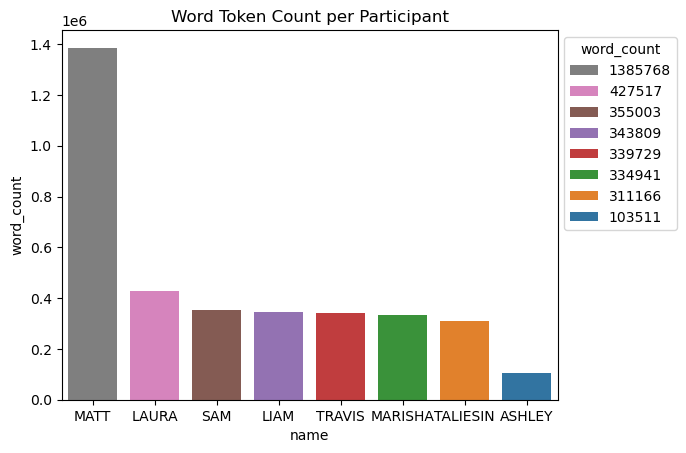

In [22]:
testplot = sns.barplot(countsdf, x="name", y="word_count", hue="word_count", dodge=False)
testplot.set_title("Word Token Count per Participant")
sns.move_legend(testplot, "upper left", bbox_to_anchor=(1, 1), reverse=True)
plt.show()

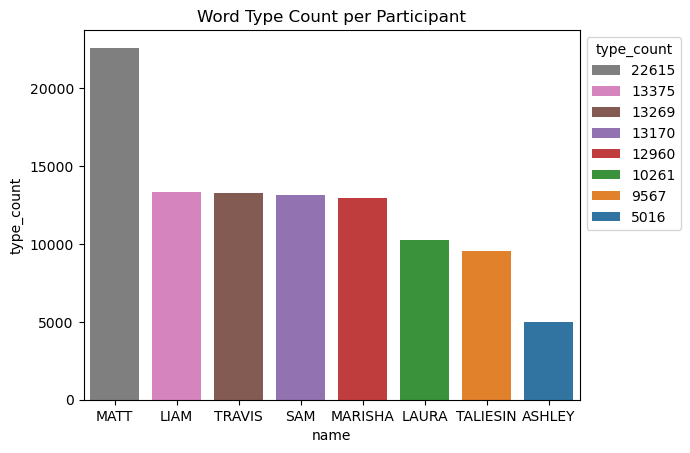

In [23]:
countsdf = countsdf.sort_values('type_count', ascending=False)

wcountplot = sns.barplot(countsdf, x="name", y="type_count", hue="type_count", dodge=False)
wcountplot.set_title("Word Type Count per Participant")
sns.move_legend(wcountplot, "upper left", bbox_to_anchor=(1, 1), reverse=True)
plt.show()

Not too much to glean from this, but an interesting look. Types seem to decrease pretty proportionally to word tokens regardless of how much speaking a player does.

### Word Length

In [24]:
wlength = cr_df.apply(lambda row: [len(w) for w in (row['nopunc'])], axis=1)
cr_df = cr_df.drop('nopunc', axis=1)

In [25]:
cr_df['avg_word_length'] = wlength.map(sum)/cr_df['word_count']
cr_df['avg_word_length'] = cr_df['avg_word_length'].fillna(0)
cr_df['avg_word_length'] = cr_df['avg_word_length'].map("{:.2f}".format)
cr_df['avg_word_length'] = cr_df['avg_word_length'].map(float)
cr_df.head()

,speech_turn,name,speech,episode,timestamp,inaudible_speech,nonspeech,word_count,types,type_count,avg_word_length
0,0,MATT,We've got some cool stuff to talk about. First...,1,00:00:15,,,155,"{there, basically, that, to, folks, digital, t...",92,3.86
1,1,LAURA,As in nnnn.,1,00:01:21,,,3,"{as, nnnn, in}",3,2.67
2,2,MATT,"Nnnn. But yeah, so they're going to be a long-...",1,00:01:24,,,122,"{there, that, start, i, through, to, digital, ...",81,4.18
3,3,TRAVIS,Would you like some?,1,00:02:04,,(vomiting noises),4,"{would, you, like, some}",4,4.00
4,4,MATT,"So yeah. I'm super excited to have that, guys....",1,00:02:07,,,129,"{hopefully, there, bunch, that, i, thank, to, ...",78,3.90


In [26]:
cr_df['avg_word_length'].describe()

count    434050.000000
mean          3.692893
std           1.235596
min           0.000000
25%           3.120000
50%           3.670000
75%           4.140000
max          31.000000
Name: avg_word_length, dtype: float64

In [27]:
cr_df[cr_df['avg_word_length']==31] #longest

,speech_turn,name,speech,episode,timestamp,inaudible_speech,nonspeech,word_count,types,type_count,avg_word_length
304806,758,SAM,You-can-respond-to-this-message.,63,01:11:18,,(quickly),1,{you-can-respond-to-this-message},1,31.0


In [28]:
cr_df[cr_df['avg_word_length']==26] #second longest

,speech_turn,name,speech,episode,timestamp,inaudible_speech,nonspeech,word_count,types,type_count,avg_word_length
18042,1603,SAM,dwarvenforge.com/wildlands.,104,02:07:44,,,1,{dwarvenforge.com/wildlands},1,26.0
412361,1903,LIAM,Ch-ch-ch-ch-ch-ch-ch-ch-ch.,94,01:37:24,,,1,{ch-ch-ch-ch-ch-ch-ch-ch-ch},1,26.0


Interesting! I guess NLTK thinks of a hyphen as part of a compound word and counts it only as one long word?
I contemplated correcting this line to separate into multiple words, but I'm not sure I want to really do that. It's written this way to convey the way Sam spoke it - in a rush, mumbled together all as one word. Auditorily speaking, I *do* think it counts as one word. 

Word length isn't very informative in this case. I'm keeping it, because I think it's interesting, but won't be using it all that much in my measurements.

### Sentences and sentence length

In [29]:
sents = cr_df.speech.map(nltk.sent_tokenize)
sents[0]   #we can take a look at that full opening speech

["We've got some cool stuff to talk about.",
 'First and foremost, we have two sponsors tonight.',
 "Our first sponsor-- and we're going into, for a time, a cool partnership with the folks at DnD Beyond, actually.",
 "They've been really awesome, and we've been talking, and anybody who hasn't seen it, it's an online digital tool where you can create your own D&D character, they have options to purchase any of the current D&D books out there, and then carry over any of the character options and racial options over into it, so you can basically use it as a tool.",
 "We'll be using it to help us out in the game as we go, 'cause it's actually got some pretty cool stuff.",
 'So excited about that.',
 "It is D-N-D Beyond, by the way, if you haven't seen, not the ampersand.",
 "It's D-N-D."]

In [30]:
sentlength = sents.map(len)    #number of sentences spoken per line
cr_df['sents_count'] = sentlength

In [31]:
cr_df['sents_count'].describe()

count    434050.000000
mean          1.197327
std           0.712285
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          27.000000
Name: sents_count, dtype: float64

27 sentences is quite a speech! I want to check this out.

In [32]:
cr_df[cr_df['sents_count']==27]

,speech_turn,name,speech,episode,timestamp,inaudible_speech,nonspeech,word_count,types,type_count,avg_word_length,sents_count
199147,135,MATT,"Yes. So as you are being led down, Rissa's poi...",25,00:17:51,,,420,"{awful, there, formation, mostly, crownsguard,...",196,4.26,27


In [33]:
cr_df.speech[199147]

'Yes. So as you are being led down, Rissa\'s pointing out some elements of it. She goes, "Okay, so over that side is the Omnismelter." She points over to a cluster of a dozen or so warehouses that are scattered in a spider web-like formation that are connected by a series of hallways between each other and then towards a central piece. She goes, "That there is where most of the foundries of the city lie. Where all the various mined ingots or those imported are melted down and utilized. The foreman there is a bit of a tool. There\'s the Armavault." She points to the far northern side of the mountain base and you see a 25, 30-foot tall by 60-foot across iron door that is solid and jammed into the side of this mountain. It looks like it\'s very well protected from this glance at the distance. From what you can see, there\'s maybe two dozen or so crownsguard that are stationed at its base. "That\'s where most of the funds that are saved for the uses of the city maintain as well as a number

Okay, cool! A lengthy introduction to a new location, it looks like. That's a big speech!

In [34]:
avgsentlength = cr_df.word_count/sentlength    #avg length of sentence per line or speech event
cr_df['avg_sent_length']=avgsentlength
cr_df['avg_sent_length'] = cr_df['avg_sent_length'].fillna(0)
cr_df['avg_sent_length'] = cr_df['avg_sent_length'].map("{:.2f}".format)
cr_df['avg_sent_length'] = cr_df['avg_sent_length'].map(float)
cr_df.head()

,speech_turn,name,speech,episode,timestamp,inaudible_speech,nonspeech,word_count,types,type_count,avg_word_length,sents_count,avg_sent_length
0,0,MATT,We've got some cool stuff to talk about. First...,1,00:00:15,,,155,"{there, basically, that, to, folks, digital, t...",92,3.86,8,19.38
1,1,LAURA,As in nnnn.,1,00:01:21,,,3,"{as, nnnn, in}",3,2.67,1,3.00
2,2,MATT,"Nnnn. But yeah, so they're going to be a long-...",1,00:01:24,,,122,"{there, that, start, i, through, to, digital, ...",81,4.18,9,13.56
3,3,TRAVIS,Would you like some?,1,00:02:04,,(vomiting noises),4,"{would, you, like, some}",4,4.00,1,4.00
4,4,MATT,"So yeah. I'm super excited to have that, guys....",1,00:02:07,,,129,"{hopefully, there, bunch, that, i, thank, to, ...",78,3.90,8,16.12


Let's take a look at some of these sentences

In [35]:
cr_df['avg_sent_length'].describe()

count    434050.000000
mean          6.643455
std           6.456691
min           0.000000
25%           2.500000
50%           5.000000
75%           8.500000
max         116.000000
Name: avg_sent_length, dtype: float64

In [36]:
#LOTS of single word sentences, not surprising!
cr_df[cr_df['avg_sent_length']==1]

,speech_turn,name,speech,episode,timestamp,inaudible_speech,nonspeech,word_count,types,type_count,avg_word_length,sents_count,avg_sent_length
22,22,LAURA,No.,1,00:06:59,,,1,{no},1,2.0,1,1.0
47,47,MARISHA,Napster.,1,00:09:09,,,1,{napster},1,7.0,1,1.0
59,59,MARISHA,Afterwards.,1,00:12:27,,,1,{afterwards},1,10.0,1,1.0
81,81,MATT,Everyone.,1,00:16:32,,,1,{everyone},1,8.0,1,1.0
128,128,LIAM,Always.,1,00:25:50,,,1,{always},1,6.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
434000,2675,"LAURA, TALIESIN, LIAM, MARISHA",Yes.,99,03:45:45,,,1,{yes},1,3.0,1,1.0
434011,2686,"ASHLEY, LAURA",Ooh!,99,03:46:03,,,1,{ooh},1,3.0,1,1.0
434041,2716,LAURA,Wow.,99,03:47:20,,,1,{wow},1,3.0,1,1.0
434042,2717,MARISHA,Wow.,99,03:47:22,,,1,{wow},1,3.0,1,1.0


In [37]:
#but what about that one long sentence?
cr_df[cr_df['avg_sent_length']==116]

,speech_turn,name,speech,episode,timestamp,inaudible_speech,nonspeech,word_count,types,type_count,avg_word_length,sents_count,avg_sent_length
354187,614,MATT,You spend some time with it on the first night...,78,00:41:55,,,116,"{than, like, there, time, some, first, both, h...",71,3.94,1,116.0


In [38]:
cr_df.speech[354187]

"You spend some time with it on the first night as you're resting around the fire, the horses are off to the side, and you're a couple of false shots, the bolts themselves, it's weird to try and wedge them both in there, and it becomes less of a firing of two bolts simultaneously more than a single bolt becomes the delivery method, that springs and fires them outward as it releases itself, so it's like a crossbow bolt that doesn't have a tip, instead it has both of the bolas tied back and so when it hits the exit point of the crossbow, it releases it and sends it forward. "

This makes sense to me! Looking into it a bit further it looks like Sam was wanting to make some alterations to his character (Nott)'s crossbow which required a skill check. He rolled a 16 (not bad) and Matt narrated the results of his efforts.

Not surprising that the narrator would narrate at length sometimes!

What is interesting is that, by written standards, it's such a run-on sentence. However, this is how the description was delivered, and was accurate to have been transcribed this way, and as a result, pinged in the data as one very long sentence!

In [39]:
sentcount = pd.DataFrame(cr_df.groupby('name').sents_count.sum())
sentcount = sentcount.reset_index()
sentcount = sentcount.sort_values('sents_count', ascending=False)

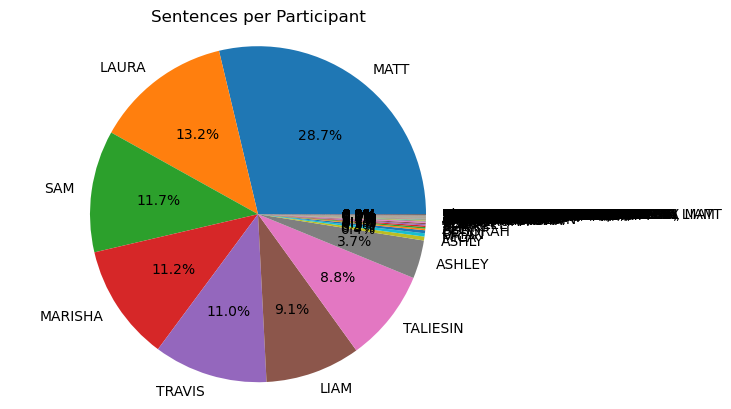

In [40]:
plt.pie(sentcount['sents_count'], labels=sentcount['name'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Sentences per Participant')
plt.show()

### Average sentence length per speaker

In [41]:
slen = pd.DataFrame(cr_df.groupby('name').avg_sent_length.mean())
slen = slen.reset_index()
slen['avg_sent_length'] = slen['avg_sent_length'].map("{:.2f}".format)
slen['avg_sent_length'] = slen['avg_sent_length'].map(float)
slen = slen.sort_values('avg_sent_length', ascending=False)

In [42]:
avgsents = slen[slen['name'].isin(['MATT', 'LIAM', 'TALIESIN', 'LAURA', 'TRAVIS', 'MARISHA', 'SAM', 'ASHLEY'])]
avgsents

,name,avg_sent_length
211,MATT,8.60
144,LIAM,6.94
312,TALIESIN,6.58
112,LAURA,6.08
337,TRAVIS,5.71
176,MARISHA,5.62
260,SAM,5.57
16,ASHLEY,5.26


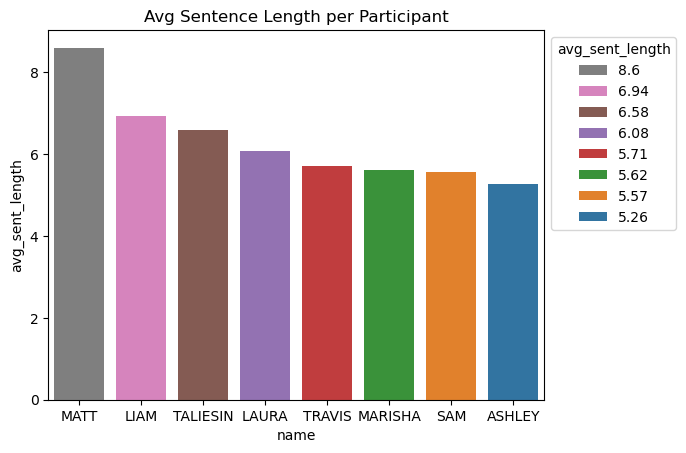

In [43]:
slenplot = sns.barplot(avgsents, x="name", y="avg_sent_length", hue="avg_sent_length", dodge=False)
slenplot.set_title("Avg Sentence Length per Participant")
sns.move_legend(slenplot, "upper left", bbox_to_anchor=(1, 1), reverse=True)
plt.show()

I had the thought... so many of the sentences in this data are extremely short, an utterance to be sure but when looking at who has longer sentence, I wanted to eliminate the shortest utterances that we've seen are confirmations, agreement, or one or two word chiming in. If we get rid of these shortest utterances, does that drastically change anything? 

I chose to measure sentences only 5 words and longer because this tokenized list still included punctuation, so anything under 5 tokens is likely a 2-3 word utterance with punctuation.

In [44]:
senttoks = [[nltk.word_tokenize(s) for s in x] for x in sents]  #word tokenize per sentence 
longsents = [[s for s in x if len(s) >= 5] for x in senttoks]  #select for sentences only 5 words or longer
longwords = [[len(w) for w in s] for s in longsents]   #word count per sentence in sents 5 words or longer
longwords2 = [sum(s) for s in longwords]  #total word count for all sents 5 words or longer

In [45]:
countsents = [len(s) for s in longsents] #count of sents >5 word long

In [46]:
avglongsent = [a/b if b else 0 for a,b in zip(longwords2,countsents)]
cr_df['avglongsent'] = avglongsent

In [47]:
slonglen = pd.DataFrame(cr_df.groupby('name').avglongsent.mean())
slonglen = slonglen.reset_index()
slonglen['avglongsent'] = slonglen['avglongsent'].map("{:.2f}".format)
slonglen['avglongsent'] = slonglen['avglongsent'].map(float)
slonglen = slonglen.sort_values('avglongsent', ascending=False)
avglong = slonglen[slonglen['name'].isin(['MATT', 'LIAM', 'TALIESIN', 'LAURA', 'TRAVIS', 'MARISHA', 'SAM', 'ASHLEY'])]

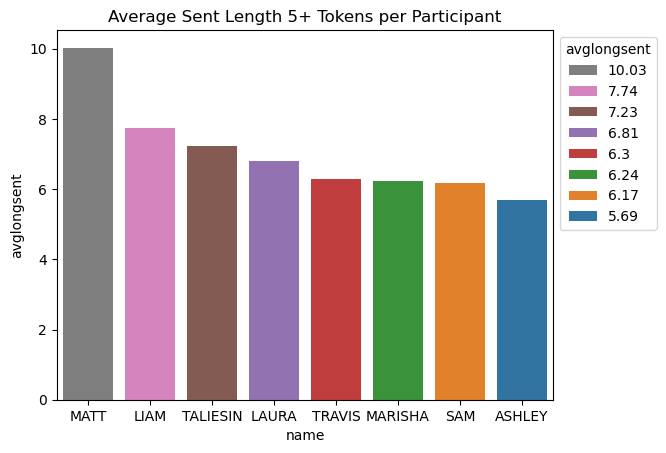

In [48]:
slongplot = sns.barplot(avglong, x="name", y="avglongsent", hue="avglongsent", dodge=False)
slongplot.set_title("Average Sent Length 5+ Tokens per Participant")
sns.move_legend(slongplot, "upper left", bbox_to_anchor=(1, 1), reverse=True)
plt.show()

In [49]:
cr_df = cr_df.drop('avglongsent', axis=1) #again we don't want this col it was just for a quick look

When removing shorter utterances, every participant's everage sentence length increases a bit. Nothing drastic happens as far as who has longer or shorter sentences though, so there's not a standout here of one participant with so many single word - three word utterances that it drastically affects their average length. Matt, the DM, actually shows the biggest change in average sentence length, from 8.6 words to 10.03.

## Initial Conlusions

djkd FINISH THIS

## Dividing the data by group

To take a look at the *dynamics* of a D&D table, I want to look at some of the metrics I've just built up when split by gender, and when split by role (DM or player). 

I've said it before, but I want to repeat it. There are four players at this table who are men, three who are women, and the DM is a man. We've already seen that, despite being outnumbered, Matt contributes an impressive amount of significant speech to the table. This group is also pretty large for a game like this, good friends and professionals who have played together for years at this point. This familiarity allows for a gracious table where everyone gets a chance to participate.

In [50]:
#we made this split before, but it excluded some important columns, so we're doing it again
ashley = pd.DataFrame(cr_df[cr_df['name']=='ASHLEY'])
matt = pd.DataFrame(cr_df[cr_df['name']=='MATT'])
marisha = pd.DataFrame(cr_df[cr_df['name']=='MARISHA'])
taliesin = pd.DataFrame(cr_df[cr_df['name']=='TALIESIN'])
sam = pd.DataFrame(cr_df[cr_df['name']=='SAM'])
liam = pd.DataFrame(cr_df[cr_df['name']=='LIAM'])
laura = pd.DataFrame(cr_df[cr_df['name']=='LAURA'])
travis = pd.DataFrame(cr_df[cr_df['name']=='TRAVIS'])

In [51]:
women = [ashley, marisha, laura]
women_df = pd.concat(women)

men = [taliesin, sam, liam, travis]
men_df = pd.concat(men)

other = cr_df[~cr_df['name'].isin(['MATT', 'LIAM', 'TALIESIN', 'LAURA', 'TRAVIS', 'MARISHA', 'SAM', 'ASHLEY'])]
#everyone who is not a main player, for the sake of graphs truly representing all data

and the DM data is obviously just..... matt

## Re-measuring

Who is talking more between groups, who says more words, has longer sentences? 

I'm going to re-measure for total line counts, word counts, and average sentence lengths.

For these measurements, to get the true scope of *total* counts, I created an "other" category, for all participants who are not the main cast. It creates a minimal dent, but I wanted an accurate measurement. 

### Lines

In [52]:
#total number of lines/speech turns for all women
womenlcount = women_df[['speech']].copy()
womenlcount = womenlcount[womenlcount['speech'] != '']
womenlcount['val'] = 'women'
womenlcount = pd.DataFrame(womenlcount['speech'].groupby(womenlcount['val']).count())
womenlcount = womenlcount.reset_index()
womenlcount['speech']

0    123711
Name: speech, dtype: int64

In [53]:
#total number of lines/speech turns for men, not including the DM
menlcount = men_df[['speech']].copy()
menlcount = menlcount[menlcount['speech'] != '']
menlcount['val'] = 'men'
menlcount = pd.DataFrame(menlcount['speech'].groupby(menlcount['val']).count())
menlcount = menlcount.reset_index()
menlcount['speech']

0    178510
Name: speech, dtype: int64

In [54]:
mattlcount = matt[['speech']].copy()
mattlcount = mattlcount[mattlcount['speech'] != '']
mattlcount['val'] = 'DM'
mattlcount = pd.DataFrame(mattlcount['speech'].groupby(mattlcount['val']).count())
mattlcount = mattlcount.reset_index()
mattlcount['speech']

0    109579
Name: speech, dtype: int64

In [55]:
othlcount = other[['speech']].copy()
othlcount = othlcount[othlcount['speech'] != '']
othlcount['val'] = 'other'
othlcount = pd.DataFrame(othlcount['speech'].groupby(othlcount['val']).count())
othlcount = othlcount.reset_index()

Now, let's keep in mind the *total* lines we already calculated.

In [56]:
#from the beginning of the notebook, blank lines already removed
lcount['speech'].count()

422576

In [57]:
mnw=[womenlcount, menlcount]
dmnw = [womenlcount, menlcount, mattlcount, othlcount]

mnwlines = pd.concat(mnw)
all_lines = pd.concat(dmnw)

Text(0.5, 1.0, 'Total Lines by Gender (Including DM)')

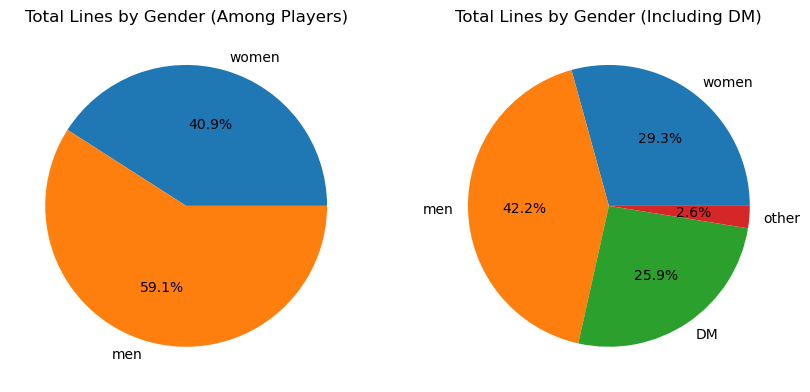

In [106]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

labels = mnwlines['val']
values = mnwlines['speech']
ax1.pie(values,labels = labels, autopct = '%1.1f%%') #plot first pie
ax1.set_title('Total Lines by Gender (Among Players)')


labels = all_lines['val']
values = all_lines['speech']
ax2.pie(values,labels = labels, autopct = '%1.1f%%') #plot second pie
ax2.set_title('Total Lines by Gender (Including DM)')

### Line % of totals

- Women players (3 people) in Critical Role Campaign 2 contributed **29.3%** of all speech turns among players
- Men players (4 people) in Critical Role Campaign 2 contributed **42.2%** of all speech turns in total
- Matt, the DM, singularly contributed almost **26%** of all speech turns

Men are producing 12.9% more lines than women in total. <br>
Between only men and women, men are producing 18.2% more lines than women<br>
*(keeping in mind again, there is one more man than there are women)*

### Word Count

In [59]:
womwcount = women_df[['word_count']].copy()
womwcount['val']='women'
womwcount = pd.DataFrame(womwcount['word_count'].groupby(womwcount['val']).sum())
womwcount = womwcount.reset_index()
womwcount.word_count

0    865969
Name: word_count, dtype: int64

In [60]:
menwcount = men_df[['word_count']].copy()
menwcount['val']='men'
menwcount = pd.DataFrame(menwcount['word_count'].groupby(menwcount['val']).sum())
menwcount = menwcount.reset_index()
menwcount.word_count

0    1349707
Name: word_count, dtype: int64

In [61]:
dmwcount = matt[['word_count']].copy()
dmwcount['val']='DM'
dmwcount = pd.DataFrame(dmwcount['word_count'].groupby(dmwcount['val']).sum())
dmwcount = dmwcount.reset_index()
dmwcount.word_count

0    1385768
Name: word_count, dtype: int64

In [62]:
othwcount = other[['word_count']].copy()
othwcount = othwcount[othwcount['word_count'] != '']
othwcount['val'] = 'other'
othwcount = pd.DataFrame(othwcount['word_count'].groupby(othwcount['val']).count())
othwcount = othwcount.reset_index()

In [63]:
mnwc = [womwcount, menwcount]
dmnwc = [womwcount, menwcount, dmwcount, othwcount]

mnwcount = pd.concat(mnwc)
dmnwcount = pd.concat(dmnwc)

Text(0.5, 1.0, 'Total Words by Gender (Including DM)')

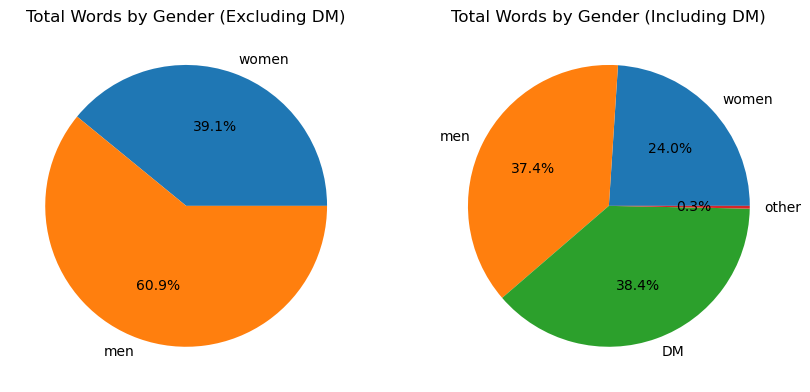

In [64]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

labels = mnwcount['val']
values = mnwcount['word_count']
ax1.pie(values,labels = labels, autopct = '%1.1f%%') #plot first pie
ax1.set_title('Total Words by Gender (Excluding DM)')


labels = dmnwcount['val']
values = dmnwcount['word_count']
ax2.pie(values,labels = labels, autopct = '%1.1f%%') #plot second pie
ax2.set_title('Total Words by Gender (Including DM)')

### Word % of totals

- Women players (3 people) in Critical Role Campaign 2 contributed **24%** of all spoken words 
- Men players (4 people) in Critical Role Campaign 2 contributed **37.4%** of all spoken words
- Matt, the DM, singularly contributed almost **38.4%** of all spoken words! So many words!

Men are producing 13.4% more lines than women in total. <br>
Between only men and women, men are producing 21.8% more lines than women<br>
*(keeping in mind again, there is one more man than there are women)*

Average word lengths were not that interesting, ~3.6 for men and women and ~3.8 for the DM. [This](https://wolfgarbe.medium.com/the-average-word-length-in-english-language-is-4-7-35750344870f) article states that the average word length in the English language is 4.7 characters. CR words on average are pretty short! Not surprising, considering the number of short function words being repeated in the data

### Sentence Length

In [65]:
womscount = women_df[['avg_sent_length']].copy()
womscount['val']='women'
womscount = pd.DataFrame(womscount['avg_sent_length'].groupby(womscount['val']).mean())
womscount = womscount.reset_index()
womscount.avg_sent_length

0    5.786185
Name: avg_sent_length, dtype: float64

In [66]:
menscount = men_df[['avg_sent_length']].copy()
menscount['val']='men'
menscount = pd.DataFrame(menscount['avg_sent_length'].groupby(menscount['val']).mean())
menscount = menscount.reset_index()
menscount.avg_sent_length

0    6.139615
Name: avg_sent_length, dtype: float64

In [67]:
mattscount = matt[['avg_sent_length']].copy()
mattscount['val']='DM'
mattscount = pd.DataFrame(mattscount['avg_sent_length'].groupby(mattscount['val']).mean())
mattscount = mattscount.reset_index()
mattscount.avg_sent_length

0    8.596282
Name: avg_sent_length, dtype: float64

In [68]:
dmnws = [womscount, menscount, mattscount]

dmnwslen = pd.concat(dmnws)

dmnwslen['avg_sent_length'] = dmnwslen['avg_sent_length'].map("{:.2f}".format)
dmnwslen['avg_sent_length'] = dmnwslen['avg_sent_length'].map(float)

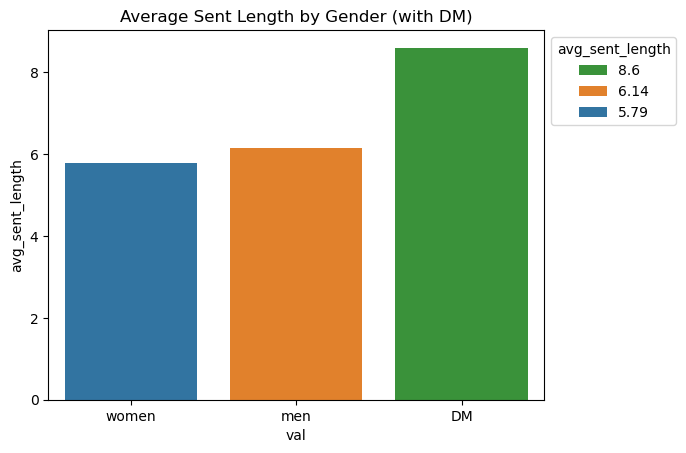

In [69]:
dmnwslenplot = sns.barplot(dmnwslen, x="val", y="avg_sent_length", hue="avg_sent_length", dodge=False)
dmnwslenplot.set_title("Average Sent Length by Gender (with DM)")
sns.move_legend(dmnwslenplot, "upper left", bbox_to_anchor=(1, 1), reverse=True)
plt.show()

### % of totals

dflksjkds FINISH THIS

## Grouped Conclusions

something about how the differences between men and women are roughly the same across metrics, which may put it down simply to attendance and who is in the cast. in none of the individual participant divisions was it dominated by men or women, actually fairly going back and forth between them. I still put that up to player and character personality alike.

## Hedging

A "softening" of language associated with cautiousness, or being unsure of oneself. Think "evidence *seems* to suggest" or "it *might* be the case that". Hedging and gender has been a topic of study for [decades](https://www.scirp.org/journal/paperinformation?paperid=103664), but it's not a simple as saying women or men use more hedging language. They use different hedging language options depending on setting, formality, politeness expectations, and for different purposes. 

In this setting, I anticipate a high number of hedging phrases to appear in DM speech than among the players of any gender.
This is because it's common for a player to prompt a dice roll by asking about their surroundings. Depending on how well they roll, it's common for the DM to say something like "it appears to be unguarded" or "it seems safe, you don't find any traps" to narrate the results. If a player rolls poorly when looking for traps, regardless of if there are or are not traps, the character they're playing doesn't know about the roll. All they know is that they looked for traps and didn't find any. Seems like it's all clear. 

We're going to be looking at a list of single words, and three phrases using list comprehension and string counts.

In [70]:
hedge = ['maybe', 'might', 'perhaps', 'possibly', 'appears', 'seems', 'suggests', 'tends']  #hedging words

In [71]:
womlist = women_df['speech'].tolist()   #get the speech column from the women only df
womlist = [w.lower() if isinstance(w, str) else w for w in womlist]   #if it is a str, lowercase and return full text
womtoks = [nltk.word_tokenize(s) for s in womlist]   #tokenize
womtoks = list(itertools.chain(*womtoks))  #flatten list of lists into one list

In [72]:
womhedg = [w for w in womtoks if w in hedge]  #return list of words in women_df speech that appear in hedging list
len(womhedg)   #get total count

2643

In [73]:
print(women_df['speech'].str.count(r'I guess').sum())   #get count for each hedging phrase
print(women_df['speech'].str.count(r'I think').sum())
print(women_df['speech'].str.count(r'[C|c]ould be').sum())

430
1593
255


In [74]:
(4921/865969)*1000  #total hedging occurences/total words * 1000

5.682651457500211

In [75]:
menlist = men_df['speech'].tolist()
menlist = [w.lower() if isinstance(w, str) else w for w in menlist]
mentoks = [nltk.word_tokenize(s) for s in menlist]
mentoks = list(itertools.chain(*mentoks))

In [76]:
menhedg = [w for w in mentoks if w in hedge]
len(menhedg)

4494

In [77]:
print(men_df['speech'].str.count(r'I guess').sum())
print(men_df['speech'].str.count(r'I think').sum())
print(men_df['speech'].str.count(r'[C|c]ould be').sum())

396
2476
403


In [78]:
(7769/1349707)*1000

5.756064093910752

In [79]:
mattlist = matt['speech'].tolist()
mattlist = [w.lower() if isinstance(w, str) else w for w in mattlist]
matttoks = [nltk.word_tokenize(s) for s in mattlist]
matttoks = list(itertools.chain(*matttoks))

In [80]:
matthedg = [w for w in matttoks if w in hedge]
len(matthedg)

2835

In [81]:
print(matt['speech'].str.count(r'I guess').sum())
print(matt['speech'].str.count(r'I think').sum())
print(matt['speech'].str.count(r'[C|c]ould be').sum())

111
577
133


In [82]:
(3656/1385768)*1000

2.6382482493462107

### Hedging Conclusions

Women have 4921 instances of hedging phrases<br>
Men have 7769 instances<br>
The DM, Matt, has 3656 instances

### Hedging Frequency

I'm be using normalized frequency to determine a frequency per thousand words for a reasonable measurement of how often jargon is appearing per group. Information about calculating this can be found [here](https://www.english-linguistics.uni-mainz.de/corpus-linguistics/american-and-british-english-corpora/more-information-about-coca-and-coha/)

With the raw count of hedging words & phrases as high as it is, I chose to calculate per 1 thousand words.<br>
For every thousand words spoken per group:<br>
**5.68** words spoken by women, <br>
**5.75** words spoken by men, and<br>
**2.6** words spoken by the DM are among the scanned for hedging words and phrases.

These totals are not what I anticipated! both groups of players express roughly equal amounts of hedging phrases, and the DM far less. However, context is important here as well. The players may engage in more hedging not out of politeness or softening of their language, but because there is a genuine lack of sureness in their speech. They don't always know what is happening in a scene, and the characters they're playing can especially be unsure.

However, when you consider that the DM is only one person and the other divisions are 3 or 4 people, he does have quite a lot all on his own! 

## Jargon

Dungeons & Dragons has a pretty unique vocabulary that can be tricky to learn and understand for new players and can be relatively unclear in meaning to those unfamiliar with the game. 

See the process I used to make a list of D&D jargon in my notebook [here](https://github.com/Data-Science-for-Linguists-2025/Critical-Role-Analysis/blob/main/notebooks/DND_Jargon.ipynb). Extracting words from the Player's Handbook that could not be dound in the Norvig Google unigram frequency list. It's not a complete collection of words I would consider "jargon-y" to the game, but it's a pretty good starting point.

In [83]:
jargon = pd.read_pickle('../pickle_jar/jargonlist.pkl') #jargon list as created in PHB_Jargon notebook
jargon[453:458]

['undercommon', 'rerolls', 'abbathor', 'tharizdun', 'caltrops']

In [84]:
womjarg = [w for w in womtoks if w in jargon]  #using the same method as hedging, list comprehend for jargon examples
len(womjarg)

264

In [85]:
menjarg = [w for w in mentoks if w in jargon]
len(menjarg)

385

In [86]:
mattjarg = [w for w in matttoks if w in jargon]
len(mattjarg)

364

### Jargon Frequency

Since our datasets, both between podcasts and between divisions of men, women, and DM are so disparate, I will be using normalized frequency again to calculate jargon frequency.

In [87]:
(264/865969)*1000000  #total instances of jargon from women / total words from women

304.8607975574183

In [88]:
(385/1349707)*1000000  #for men

285.24709436937053

In [89]:
(364/1385768)*1000000   #for dm

262.67023051477594

### Jargon Results

With the range of total words per group being in the 860,000-1.38 million words, I've chosen to calculate the frequency of jargon per million words. 

What this means is that for every million words spoken by the members of the group in question:<br>
**304.8** words spoken by the women players,<br>
**285.2** words spoken by men players, and<br>
**262.6** words spoken by the DM will be from this jargon list.<br>
<br>
<br>
Which words from the list of D&D jargon are being used? 

In [90]:
from wordcloud import WordCloud

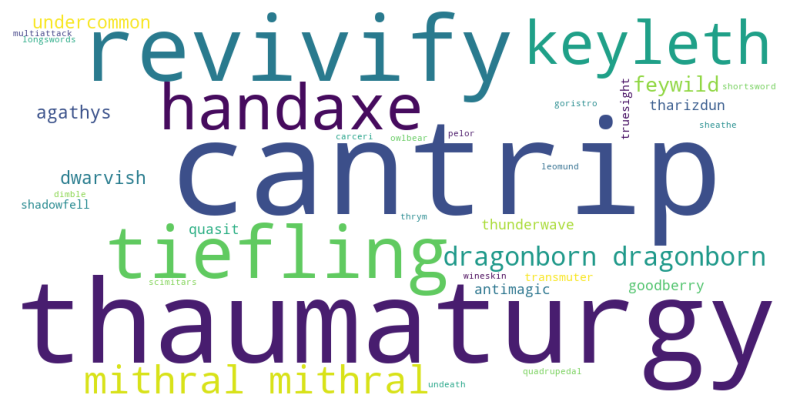

In [91]:
unique_string=(" ").join(womjarg)
wordcloud = WordCloud(background_color='white', width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(11,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()

### Women

Among the women, Laura played a tiefling and a healer, she would have been casting cantrips and spells like thaumaturgy and revivify quite a lot. Others are common weapons, locations, races, languages etc. 

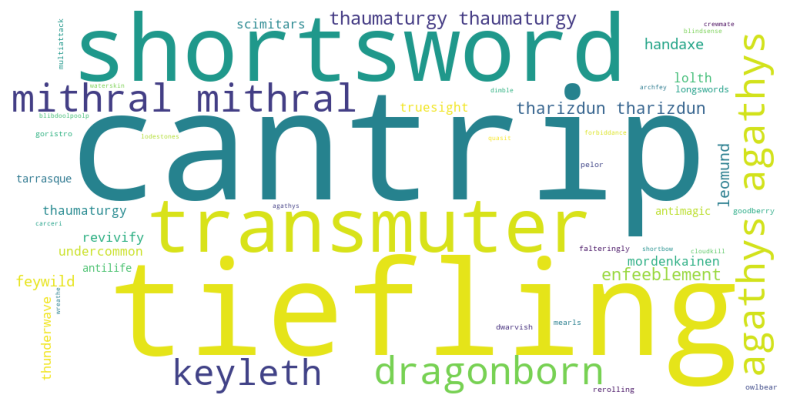

In [92]:
unique_string=(" ").join(menjarg)
wordcloud = WordCloud(background_color='white', width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(11,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()

### Men

Among the men, one of them played a tiefling for a short time (27-ish episodes). One played a wizard, one was a healer, and the other two were fighting types with magic abilities. It's not a shock, then, that again cantrip would be used so much. Transmuter is related to the wizard class, enfeeblement is a spell, and agathys is a magical armor one of them had

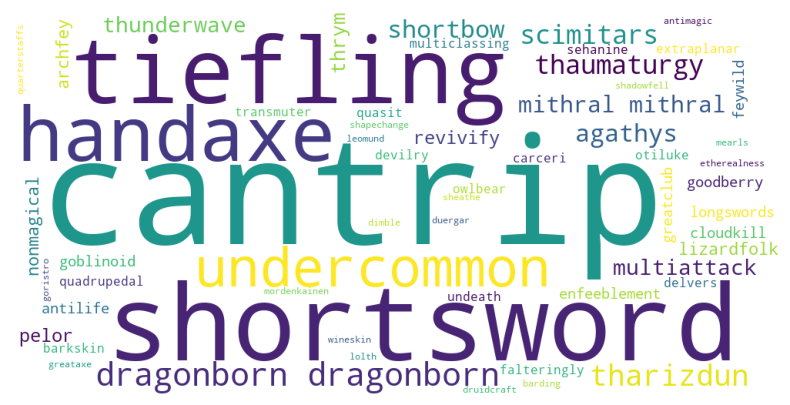

In [93]:
unique_string=(" ").join(mattjarg)
wordcloud = WordCloud(background_color='white', width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(11,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### DM

It appears that a good chunk of the jargon used by the DM comes during combat narrations. Some of the enemies he controls would have all these weapons listed here, or speak undercommon. His cloud has more races listed like lizardfolk, actions like multiattack, and names of gods in D&D lore like Pelor, Tharizdun, Lolth.

## Readability Metric

### Flesch–Kincaid readability test

Reminder that the calculation for the readability score is:<br>
<img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/bd4916e193d2f96fa3b74ee258aaa6fe242e110e>

In [94]:
from nltk.tokenize import SyllableTokenizer
import warnings
warnings.filterwarnings('ignore')

In [95]:
SSP = SyllableTokenizer()

### Women

In [96]:
wnopunc = [w for w in womtoks if w not in punctuations]  #removing punctuation for syl tokenizer
wsyls = [SSP.tokenize(w) for w in wnopunc] #syl tokenize for each tokenized word
wsylcount = [len(w) for w in wsyls]   #count syllable per word in full list
sum(wsylcount)  #total count all syllables for women

1182614

In [97]:
#readability calculation for women speech

206.853-(1.015*(865969/145926))-(84.6*(1182614/865969))

85.29535755398143

In [98]:
#grade score for women speech 

(0.39*(865969/145926))+(11.8*(1182614/865969))-15.59

2.8390947124384454

### Men

In [99]:
mnopunc = [w for w in mentoks if w not in punctuations]  
msyls = [SSP.tokenize(w) for w in mnopunc] 
msylcount = [len(w) for w in msyls]   
sum(msylcount) 

1861455

In [100]:
#readability calculation for men speech

206.853-(1.015*(1349707/211423))-(84.6*(1861455/1349707))

83.69682056505413

In [101]:
#grade score for men speech 

(0.39*(1349707/211423))+(11.8*(1861455/1349707))-15.59

3.173755466471036

### DM

In [102]:
dmnopunc = [w for w in matttoks if w not in punctuations]  
dmsyls = [SSP.tokenize(w) for w in dmnopunc] 
dmsylcount = [len(w) for w in dmsyls]   
sum(dmsylcount) 

2037971

In [103]:
#readability calculation for DM speech

206.853-(1.015*(1385768/149314))-(84.6*(2037971/1385768))

73.01643024651871

In [104]:
#grade score for DM speech 

(0.39*(1385768/149314))+(11.8*(2037971/1385768))-15.59

5.383146049621658

## Readability Conclusions

FINISH THIS

something about how to take this very cautiously because it's for reading not for spoken lang but it's interesting to see

## Interruptions

FINISH THIS

something about how i planned to inverstigate interruptions but the format of the data isn't really suitable for it and timestamps don't really help, at least not for the scope of this project. It would take more exploration and actually listening through/watching the episodes.

In [105]:
ep2 = cr_df[cr_df['episode']=='2']
ep2[-130:-120]

,speech_turn,name,speech,episode,timestamp,inaudible_speech,nonspeech,word_count,types,type_count,avg_word_length,sents_count,avg_sent_length
185091,2564,MATT,"At which point, the flap of the tent opens up ...",2,04:01:13,,,14,"{of, point, 's, flap, opens, at, it, the, and,...",13,3.43,1,14.0
185092,2565,LAURA,It's Ornna!,2,04:01:17,,,3,"{'s, it, ornna}",3,3.00,1,3.0
185093,2566,SAM,"Ornna, you have a lot of explaining to do!",2,04:01:19,,,9,"{lot, of, have, to, you, explaining, do, a, or...",9,3.56,1,9.0
185094,2567,MARISHA,Shut up!,2,04:01:20,,,2,"{up, shut}",2,3.00,1,2.0
185095,2568,SAM,You have a lot of explaining to do!,2,04:01:21,,,8,"{lot, of, have, to, you, explaining, do, a}",8,3.38,1,8.0
185096,2569,MARISHA,Shut up!,2,04:01:22,,,2,"{up, shut}",2,3.00,1,2.0
185097,2570,SAM,We've talked to Toya. She knows it's you who d...,2,04:01:24,,,13,"{'ve, talked, to, 's, she, you, who, did, we, ...",13,3.23,2,6.5
185098,2571,LAURA,We know you guys are in a fight all the time.,2,04:01:28,,,11,"{know, all, time, fight, you, we, the, are, a,...",11,3.09,1,11.0
185099,2572,SAM,You're the one behind the whole plot! You did ...,2,04:01:30,,,11,"{one, whole, you, did, behind, it, the, 're, p...",9,3.45,2,5.5
185100,2573,LAURA,You!,2,04:01:32,,,1,{you},1,3.00,1,1.0


a link to the moment of chaos, just for comparison - this is a good reference point for chaos and overlapping speech

https://youtu.be/MPELLuQXVcE?si=13too39HcHj5Cfow&t=14475